<a href="https://colab.research.google.com/github/Sandwhaletree/2023.05_Tibame/blob/main/%E9%80%B2%E9%9A%8EDL_%E6%9D%8E%E6%99%BA%E6%8F%9A_Class/001_PyTorch_Linear_CIFAR10_0713.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Basic module
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # progress bar

# PyTorch
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms # 資料前處理

In [2]:
# print version of PyTorch
torch.__version__, torchvision.__version__

('2.0.1+cu118', '0.15.2+cu118')

In [3]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


#### Prepare CIFAR10 Dataset

*   torch vision datasets: https://pytorch.org/vision/stable/datasets.html
*   CIFAR10 label

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck

In [4]:
# Define Parameters
NUM_CLASS = 10 #類別數定義
# Class name and class mapping
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]
class_map = {cls: i for i, cls in enumerate(class_names)}
print(class_map)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


#### torch.utils.data.Dataset

https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset

*   read **1** sample (img, label)
*   Convert to **Torch.Tensor**
* Datasets provided by torchvision https://pytorch.org/vision/stable/datasets.html

In [5]:
# Download dataset
train_ds = torchvision.datasets.CIFAR10('data', # saved path #訓練資料
    train=True, # training or testing set
    download=True # download dataset from internet
)
val_ds = torchvision.datasets.CIFAR10('data', #驗證資料
    train=False,
    download=True
)

100%|██████████| 170498071/170498071 [00:05<00:00, 29045227.33it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [6]:
# Check your dataset
print('Number of training   samples:', len(train_ds))
print('Number of validation samples:', len(val_ds))

Number of training   samples: 50000
Number of validation samples: 10000


In [7]:
# Random select a sample
idx = np.random.randint(low=0, high=len(train_ds))
img, label = train_ds[idx]

# Type of img and label
print(idx)
print(type(img), type(label))

32187
<class 'PIL.Image.Image'> <class 'int'>


img shape:  (32, 32, 3)
label:  7
class name:  horse


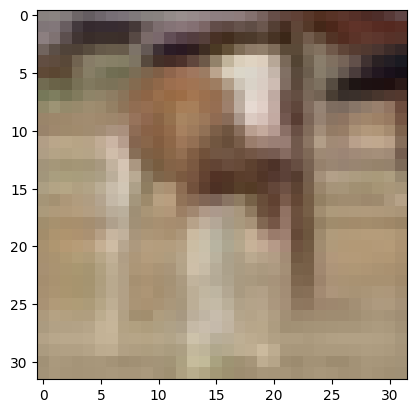

In [8]:
# Convert to np.ndarray and show image
img_np = np.array(img)
print('img shape: ', img_np.shape)
print('label: ', label)
print('class name: ', class_names[label])
plt.imshow(img_np)
plt.show()

#### Data Proprocess



1.   Convert **PIL.Image** to **torch.FloatTensor** (張量)
  

*   Converts a **PIL Image or numpy.ndarray** (H, W, C) in the range [0, 255] to a **torch.FloatTensor** of shape (C, H, W) in the range [0.0, 1.0]

2.   TODO: Data Augmentation, ... etc

In [9]:
preprocess = transforms.Compose([
    transforms.ToTensor(), # Convert to Tensor
    # ...
])

In [10]:
# Build dataset with data preprocess
train_ds = torchvision.datasets.CIFAR10('data',
    train=True,
    download=True,
    transform=preprocess)
val_ds = torchvision.datasets.CIFAR10('data',
    train=False,
    download=True,
    transform=preprocess)

Files already downloaded and verified
Files already downloaded and verified


#### Combine Dataset with DataLoader

**torch.utils.data.DataLoader**: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

* form a **batch**
* data sampler
* reading order (shuffle)

In [11]:
# Use DataLoader to generate minibatches
BATCH_SIZE = 256
train_dataloader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True)
val_dataloader = torch.utils.data.DataLoader(
    val_ds,
    batch_size=BATCH_SIZE)

Check shape of data

N: number of samples

C: channels

H: Height

W: Width

**PyTorch use channel first !**

In [12]:
for x, y in train_dataloader:
    print("type ", type(x), type(y))
    print("Shape of x [N, C, H, W]: ", x.shape, x.dtype)
    print("Shape of y [N]: ", y.shape, y.dtype)
    break

type  <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of x [N, C, H, W]:  torch.Size([256, 3, 32, 32]) torch.float32
Shape of y [N]:  torch.Size([256]) torch.int64


(<matplotlib.image.AxesImage at 0x7b1fcf0f9990>, tensor(2))

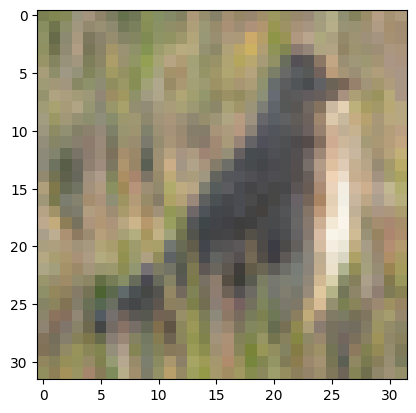

In [13]:
# permute: [C, H, W] -> [H, W, C]
plt.imshow(x[0].permute(1, 2, 0)), y[0]

#### Build Model

In [14]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

IMG_SIZE = 32

Using device: cpu


nn.Sequential

In [15]:
model = nn.Sequential(
    nn.Flatten(), # (C, H, W) -> (C*H*W)
    nn.Linear(in_features=IMG_SIZE*IMG_SIZE*3, out_features=64), # (C*H*W) -> (64)
    nn.ReLU(), # activation
    nn.Linear(64, 128), # (64) -> (128)
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, NUM_CLASS), # (128) -> NUM_CLASS
)

nn.Module Subclass

In [16]:
# Define model
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # (C, H, W) -> (C*H*W)
        self.base_model = nn.Sequential(
            nn.Linear(in_features=IMG_SIZE*IMG_SIZE*3, out_features=64), # (C*H*W) -> (64)
            nn.ReLU(),
            nn.Linear(64, 128), # (64) -> (128)
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, NUM_CLASS), # (128) -> NUM_CLASS
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.base_model(x)
        return logits

In [17]:
# init model and move to GPU device
model = NeuralNet().to(device)

In [18]:
# Print basic model architecture
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (base_model): Sequential(
    (0): Linear(in_features=3072, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [19]:
# Use torchsummary to print advanced info
import torchsummary

torchsummary.summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 64]         196,672
              ReLU-3                   [-1, 64]               0
            Linear-4                  [-1, 128]           8,320
              ReLU-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 222,794
Trainable params: 222,794
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.85
Estimated Total Size (MB): 0.89
----------------------------------------------------------------


In [20]:
# Use torchinfo to print advanced info
!pip install torchinfo

import torchinfo
torchinfo.summary(model, input_size=(BATCH_SIZE, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNet                                [256, 10]                 --
├─Flatten: 1-1                           [256, 3072]               --
├─Sequential: 1-2                        [256, 10]                 --
│    └─Linear: 2-1                       [256, 64]                 196,672
│    └─ReLU: 2-2                         [256, 64]                 --
│    └─Linear: 2-3                       [256, 128]                8,320
│    └─ReLU: 2-4                         [256, 128]                --
│    └─Linear: 2-5                       [256, 128]                16,512
│    └─ReLU: 2-6                         [256, 128]                --
│    └─Linear: 2-7                       [256, 10]                 1,290
Total params: 222,794
Trainable params: 222,794
Non-trainable params: 0
Total mult-adds (M): 57.04
Input size (MB): 3.15
Forward/backward pass size (MB): 0.68
Params size (MB): 0.89
Estimated Total Size (MB): 4

#### Training: Optimizing the Model Parameters

In [21]:
loss_fn = nn.CrossEntropyLoss() # Softmax + negative log likelihood loss (nn.NLLLoss)
optimizer = torch.optim.SGD(
    params=model.parameters(), # parameters to optimize
    lr=1e-2, # learning rate: 1e-4, 1e-2...
)

In [23]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to device

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [24]:
EPOCHS = 10
logs = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_dataloader, model, loss_fn)

    print(f'EPOCH: {epoch} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 0     train_loss: 2.2937, train_acc: 0.122     val_loss: 2.2809, val_acc: 0.135 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 1     train_loss: 2.2602, train_acc: 0.146     val_loss: 2.2314, val_acc: 0.166 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 2     train_loss: 2.1881, train_acc: 0.177     val_loss: 2.1381, val_acc: 0.190 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 3     train_loss: 2.0950, train_acc: 0.221     val_loss: 2.0561, val_acc: 0.248 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 4     train_loss: 2.0297, train_acc: 0.260     val_loss: 2.0083, val_acc: 0.272 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 5     train_loss: 1.9854, train_acc: 0.275     val_loss: 1.9724, val_acc: 0.279 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 6     train_loss: 1.9496, train_acc: 0.291     val_loss: 1.9362, val_acc: 0.296 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 7     train_loss: 1.9193, train_acc: 0.305     val_loss: 1.9038, val_acc: 0.307 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 8     train_loss: 1.8940, train_acc: 0.316     val_loss: 1.8866, val_acc: 0.317 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 9     train_loss: 1.8742, train_acc: 0.325     val_loss: 1.8828, val_acc: 0.317 


#### Logs

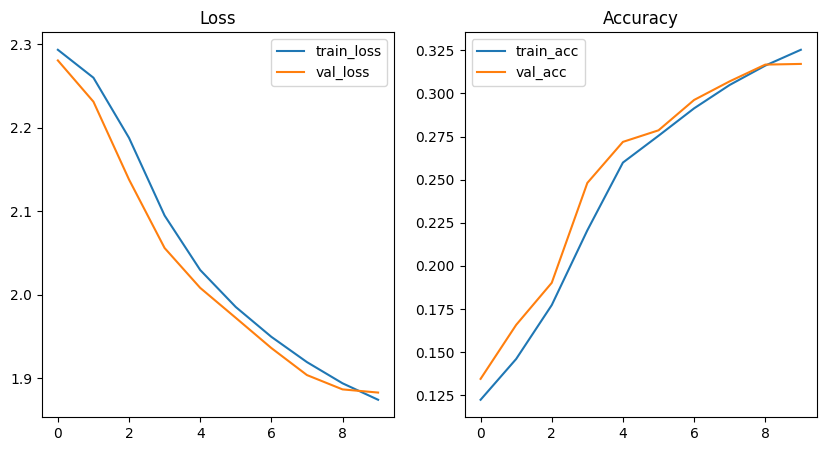

In [25]:
# Plot loss curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(logs['train_loss'])
plt.plot(logs['val_loss'])
plt.legend(['train_loss', 'val_loss'])
# plot acc
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(logs['train_acc'])
plt.plot(logs['val_acc'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

#### Save Model

Saving & Loading Model (weights only)

**Recommended**

In [27]:
# model parameters>透過.state_dict()獲得
model.state_dict()

OrderedDict([('base_model.0.weight',
              tensor([[ 0.0086, -0.0173, -0.0002,  ...,  0.0076,  0.0016,  0.0164],
                      [ 0.0135,  0.0122, -0.0082,  ..., -0.0038, -0.0051, -0.0068],
                      [ 0.0123, -0.0028, -0.0042,  ...,  0.0094, -0.0051, -0.0091],
                      ...,
                      [ 0.0021, -0.0052,  0.0157,  ...,  0.0272,  0.0066,  0.0173],
                      [ 0.0088,  0.0167, -0.0154,  ..., -0.0045,  0.0017, -0.0065],
                      [-0.0049,  0.0216,  0.0008,  ...,  0.0188,  0.0130, -0.0041]])),
             ('base_model.0.bias',
              tensor([-0.0039,  0.0348,  0.0247, -0.0320,  0.0184,  0.0063,  0.0024, -0.0256,
                      -0.0108, -0.0098,  0.0216, -0.0105,  0.0033, -0.0419,  0.0233,  0.0323,
                      -0.0096, -0.0177,  0.0251,  0.0167, -0.0244, -0.0101,  0.0264,  0.0169,
                       0.0025, -0.0149,  0.0126,  0.0345, -0.0011,  0.0143,  0.0047,  0.0044,
                  

In [26]:
PATH = './model_weights.pth'
# save weights
torch.save(model.state_dict(), PATH)

# load weights
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Saving & Loading Model (entire model)

In [28]:
MODEL_PATH = './model.pth'
# save model
torch.save(model, MODEL_PATH)
# load model
model = torch.load(MODEL_PATH)

#### Evaluation

In [29]:
# load model
model = NeuralNet()

model.load_state_dict(torch.load(PATH))
model.eval()

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (base_model): Sequential(
    (0): Linear(in_features=3072, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

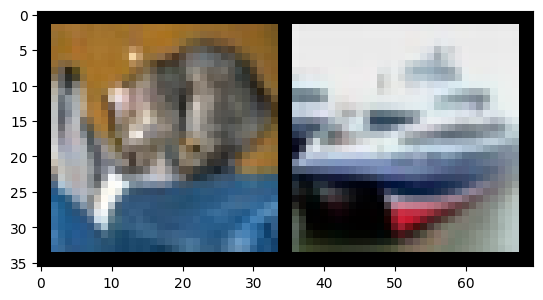

In [30]:
# take first 2 images
n = 2
for (images, labels) in val_dataloader:
    images, labels = images[:n], labels[:n]
    images_grid = torchvision.utils.make_grid(images[:n])
    images_grid = images_grid.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
    plt.imshow(images_grid.numpy())
    break

In [31]:
# take first 2 images
n = 2
for (images, labels) in val_dataloader:
    images, labels = images[:n], labels[:n]
    break

# Predict by model
with torch.no_grad():
    pred = model(images) # predict logits
print('raw_prediction logtis', pred, pred.shape, sep="\n")

raw_prediction logtis
tensor([[-0.3993,  0.0278,  0.2435,  0.7078,  0.1771,  0.8769,  0.0630, -0.3083,
         -0.4939, -1.0681],
        [ 0.3500,  3.0835, -1.6331, -0.7447, -2.1139, -1.8306, -1.8176, -0.8185,
          2.6153,  3.6537]])
torch.Size([2, 10])


In [32]:
pred_softmax = nn.Softmax(dim=1)(pred) # probabilities
print('prediction after softmax', pred_softmax, pred_softmax.shape, sep="\n")

prediction after softmax
tensor([[0.0591, 0.0905, 0.1123, 0.1787, 0.1051, 0.2117, 0.0938, 0.0647, 0.0537,
         0.0303],
        [0.0184, 0.2832, 0.0025, 0.0062, 0.0016, 0.0021, 0.0021, 0.0057, 0.1773,
         0.5009]])
torch.Size([2, 10])


In [33]:
# max_prob: max probability of each samples
# predicted_cls: the index of max prob
max_prob, predicted_cls = torch.max(pred_softmax, dim=1) #在10維度，最大的資料為何

In [34]:
predicted_cls = pred_softmax.argmax(dim=1)

In [35]:
predicted_cls

tensor([5, 9])

In [36]:
pred_softmax.argmax(dim=1)

tensor([5, 9])

In [37]:
print('GroundTruth: ', ' '.join(class_names[labels[j]] for j in range(n)))
print('Prediction: ', ' '.join(class_names[predicted_cls[j]] for j in range(n)))

GroundTruth:  cat ship
Prediction:  dog truck
